This notebook performs all post-processing of allelic data that is included in the paper regarding scRNA-seq allelic kinetics of XCU

The input data is the matrix generated by Bart in notebooks: 

**conda env: R_scRNAseq**

In [1]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(ggplot2)
    library(tidyr)
    suppressMessages(library(viridis))
})

Warning message:
"package 'Seurat' was built under R version 3.6.2"

In [8]:
allelic <- read_csv("allele_specific/pre_processing/AJ_0065.9c_allelic_norm_complete.csv") %>%
                rename("cluster_replace" = "seurat_clusters_rename")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  gene = col_character(),
  RNA_id = col_character(),
  X = col_double(),
  X129 = col_double(),
  Cast = col_double(),
  sumReads = col_double(),
  ratioPercent = col_double(),
  ratioLog = col_double(),
  Pseudotime = col_double(),
  seurat_clusters_rename = col_double(),
  Timepoint = col_character(),
  Xi = col_character(),
  Chr = col_character(),
  total_reads = col_double(),
  mus_norm = col_double(),
  cast_norm = col_double(),
  ratio_norm = col_double(),
  sum_norm = col_double()
)


In [9]:
head(allelic)

X1,gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,cluster_replace,Timepoint,Xi,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
1,0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,2,Day_10,Mus,chr11,88329,0.00000000,0.0000000,NA,0.0000000
2,0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,3,Day_10,Mus,chr11,10125,0.00000000,0.0000000,NA,0.0000000
3,0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,2,Day_10,Mus,chr11,115942,0.00000000,0.2963941,0.0000000,0.2963941
4,0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,1,Day_12,Mus,chr11,142685,0.06773757,0.3991728,0.1450762,0.4669104
5,0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,4,Day_12,Mus,chr11,202247,0.00000000,0.0000000,NA,0.0000000
6,0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,2,Day_9,Mus,chr11,181032,0.19963368,0.0000000,1.0000000,0.1996337


In [10]:
chrX <- allelic %>% filter(Chr=="chrX") %>% select(gene,RNA_id,mus_norm,cast_norm,Pseudotime)
chrX$Sum <- chrX$mus_norm + chrX$cast_norm
chrX <- chrX %>% filter(Sum > 0) %>%group_by(RNA_id, Pseudotime) %>%
    summarise(mus = mean(mus_norm), cast = mean(cast_norm), sum = mean(Sum))
chrX <- chrX %>% gather(allele,expression,-RNA_id,-Pseudotime)
sum <- chrX %>% filter(allele == "sum")
chrX <- chrX %>% filter(allele != "sum")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


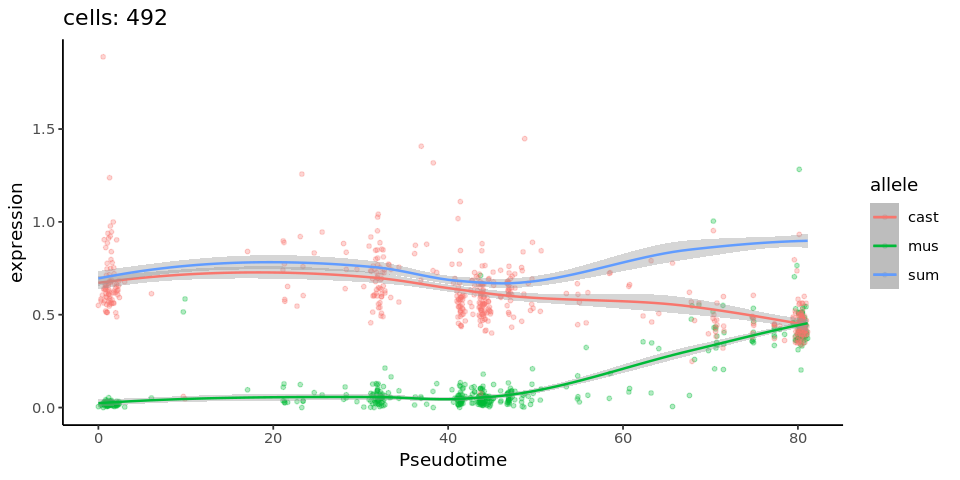

In [11]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(chrX, aes(Pseudotime, expression, color=allele)) +
                geom_point(size = 1, alpha = 0.3, aes(color = allele)) +
                geom_smooth(aes(group=allele), size = .7) +    
                geom_smooth(data=sum, aes(Pseudotime, expression), size = .7) +
                ggtitle(paste0("cells: ", length(unique(chrX$RNA_id)))) +
                theme_classic() 

In [12]:
notA <- c("chrX", "chrY", "chrM")


filter <- c(0)
#filter <- 0
plotA2 <- list()
plotD2 <- list()

for(i in 1:length(filter)){
allelic2 <- allelic %>% filter(sum_norm > filter[i])
    
A <- allelic2 %>% filter(!Chr %in% notA) %>% select(RNA_id, mus_norm, cast_norm, sum_norm, cluster_replace, Pseudotime)
A <- A %>% group_by(RNA_id, Pseudotime, cluster_replace) %>% summarize(meanA = median(sum_norm), castA = median(cast_norm), musA = median(mus_norm))
    
X <- allelic2 %>% filter(Chr == "chrX") %>% select(RNA_id, mus_norm, cast_norm, sum_norm)
X <- X %>% group_by(RNA_id) %>% summarize(castX = median(cast_norm), musX = median(mus_norm), meanX = median(sum_norm))

XA <- merge(A, X, by="RNA_id")
XA$castXA <- XA$castX/XA$meanA
XA$musXA <- XA$musX/XA$meanA

plot <- XA %>% gather(allele, mean, -RNA_id, -Pseudotime, -cluster_replace)

plotA <- plot %>% filter(allele=="castXA" | allele=="musXA")

options(repr.plot.width=5, repr.plot.height=2)
plotA2[[i]] <- ggplot(plotA, aes(Pseudotime, mean, color=allele)) +
                geom_point(size = 1, alpha = 0.3, aes(color = allele)) +
                geom_smooth(aes(group=allele), size = .7) +    
                ggtitle(paste0("cells: ", length(unique(chrX$RNA_id)), ", sum_norm > ", filter[i])) +
                theme_classic() + ylab("X/A ratio")
    
plotD <- plot %>% filter(allele=="castX" | allele=="musX" | allele=="meanA")
options(repr.plot.width=5, repr.plot.height=3)
plotD2[[i]] <- ggplot(plotD, aes(Pseudotime, mean, color=allele)) +
                geom_point(size = 1, alpha = 0.3, aes(color = allele)) +
                geom_smooth(aes(group=allele), size = .7) +    
                ggtitle(paste0("cells: ", length(unique(chrX$RNA_id)), ", sum_norm > ", filter[i])) + ylim(0,1.05) +
               # + ylab("Median Expression")
                scale_color_manual(name="Allele",
                    values=c(meanA="#22A024", castX="#FF6565", musX = "#377AFF")) +
                theme_classic()    
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


[[1]]


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 20 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 20 rows containing missing values (geom_point)."Warning message:
"Removed 10 rows containing missing values (geom_smooth)."

[[1]]


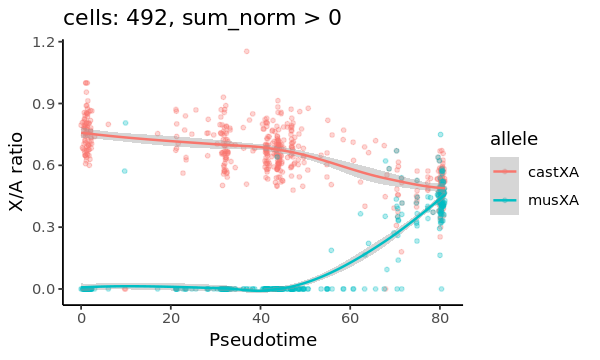

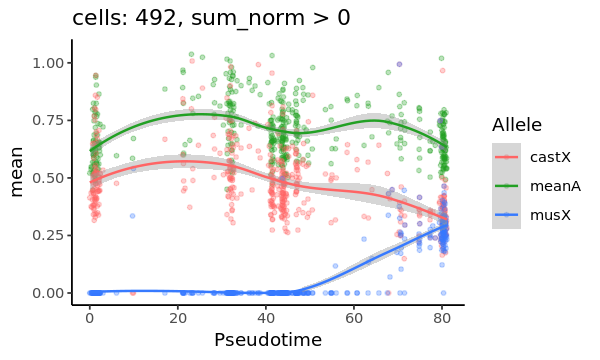

In [13]:
plotA2
plotD2

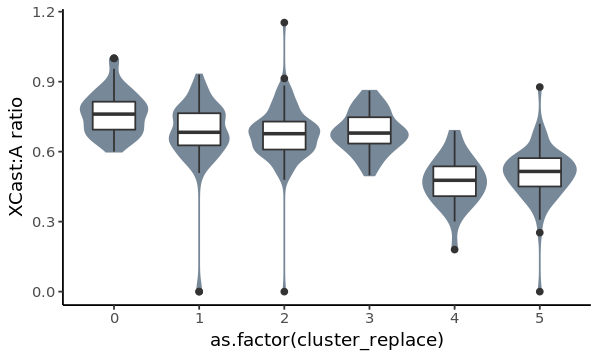

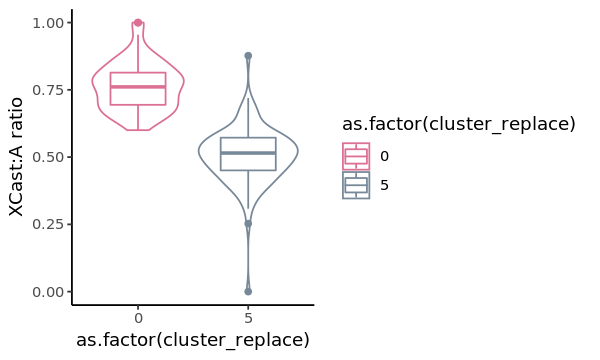

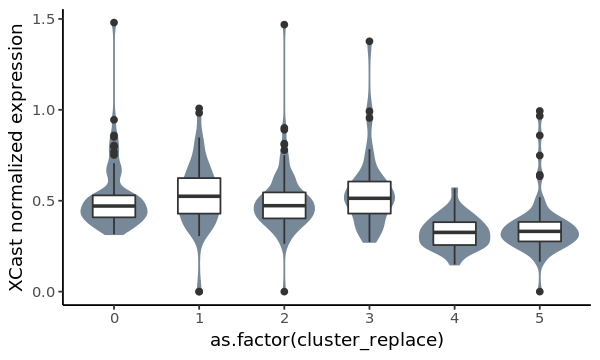

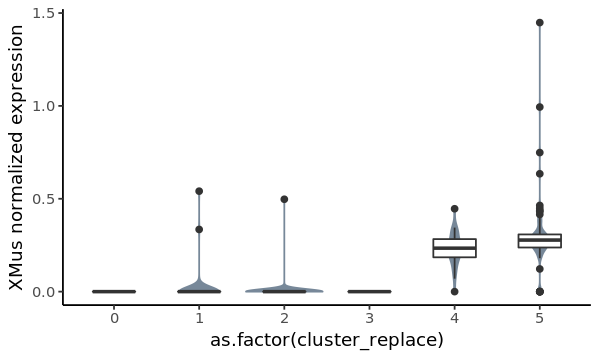

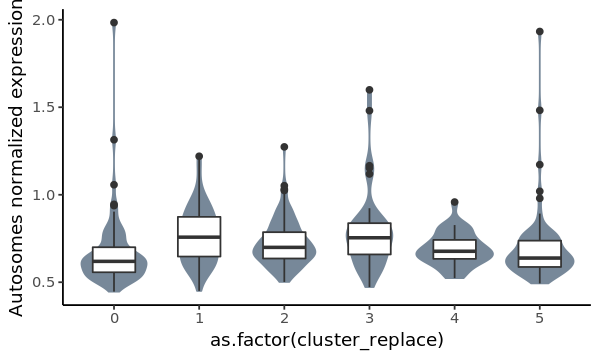

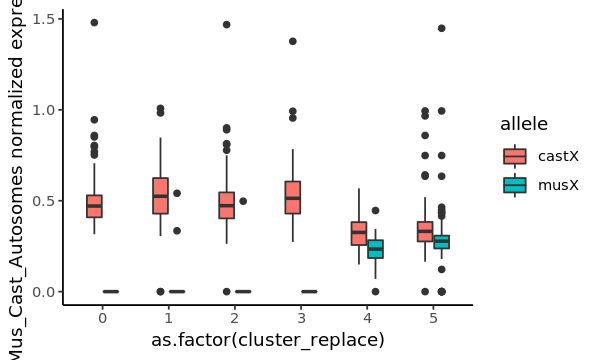

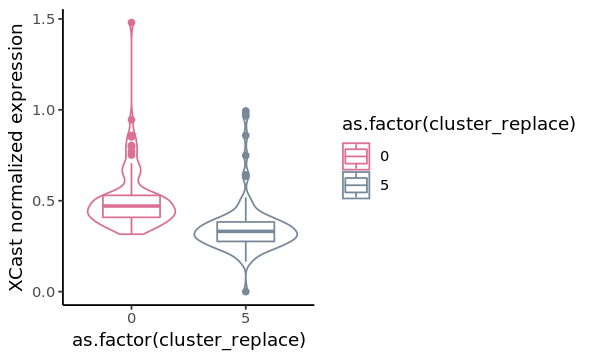

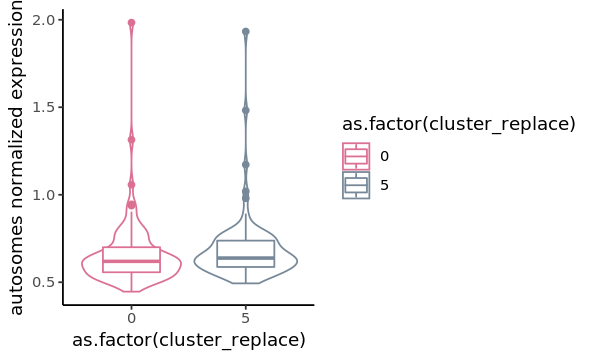

In [67]:
# Plot box plot X/A ratio in MEF vs iPSCs and check with statistics
options(repr.plot.width=5, repr.plot.height=3)

# Cast X/A ratio - all clusters
all_CastXA_violin <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                ylab("XCast:A ratio")+
                theme_classic()
all_CastXA_violin


# Cast X/A ratio
C0_C5_CastXA_violin <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin()+
                geom_boxplot(width = 0.5) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast:A ratio")
C0_C5_CastXA_violin

# Cast abs expression - all clusters
all_absCastX_violin <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast normalized expression")
all_absCastX_violin

# Mus abs expression - all clusters
all_absMusX_violin <- plotD %>% filter(allele=="musX", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XMus normalized expression")
all_absMusX_violin

# Autosomes abs expression - all clusters
all_absAuto_violin <- plot %>% filter(allele=="meanA", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("Autosomes normalized expression")
all_absAuto_violin

# Autosomes + Cast + Mus abs expression - all clusters
all_abs_violin <- plot %>% filter(allele %in% c("musX","castX"),cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, fill = allele)) +
                #geom_violin()+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("Mus_Cast_Autosomes normalized expression")
all_abs_violin



# Cast abs expression
C0_C5_absCastX_violin <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin()+
                geom_boxplot(width = 0.5) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast normalized expression")
C0_C5_absCastX_violin

# Autosomes absolute expresssion
C0_C5_absA_violin <- plotD %>% filter(allele=="meanA", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin(position=position_dodge())+
                geom_boxplot(width = 0.5,position=position_dodge()) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("autosomes normalized expression")
C0_C5_absA_violin

In [11]:
pdf("allele_specific/XCU/C0_C5_CastXA_violin.pdf", useDingbats = FALSE, width = 5, height = 3)
plot(C0_C5_CastXA_violin)
dev.off()

png 
  2

In [12]:
pdf("allele_specific/XCU/C0_C5_absCastX_violin.pdf", useDingbats = FALSE, width = 5, height = 3)
plot(C0_C5_absCastX_violin)
dev.off()

png 
  2

In [13]:
pdf("allele_specific/XCU/C0_C5_absA_violin.pdf", useDingbats = FALSE, width = 5, height = 3)
plot(C0_C5_absA_violin)
dev.off()

png 
  2

In [73]:
print("rank-sum test with X/A ratio C0 vs C5")
test_data <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0,5))  
res <- wilcox.test(mean ~ as.factor(cluster_replace), data = test_data,
                   exact = FALSE)
res
res$p.value

print("rank-sum test with absolute expression C0 vs C5")
test_data <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0,5))  
res <- wilcox.test(mean ~ as.factor(cluster_replace), data = test_data,
                   exact = FALSE)
res
res$p.value

print("rank-sum test with absolute expression C0 vs C5 for autosomes")
test_data <- plotD %>% filter(allele=="meanA", cluster_replace %in% c(0,5))  
res <- wilcox.test(mean ~ as.factor(cluster_replace), data = test_data,
                   exact = FALSE)
res
res$p.value

[1] "rank-sum test with X/A ratio C0 vs C5"



	Wilcoxon rank sum test with continuity correction

data:  mean by as.factor(cluster_replace)
W = 7874, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] 3.241472e-28

[1] "rank-sum test with absolute expression C0 vs C5"



	Wilcoxon rank sum test with continuity correction

data:  mean by as.factor(cluster_replace)
W = 6913, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] 1.465126e-16

[1] "rank-sum test with absolute expression C0 vs C5 for autosomes"



	Wilcoxon rank sum test with continuity correction

data:  mean by as.factor(cluster_replace)
W = 3384, p-value = 0.06337
alternative hypothesis: true location shift is not equal to 0


[1] 0.0633696

In [ ]:
# Repeat the level of XCU and dynamics of XCU erasure using only genes that were defined as upregulating
# ... using XO cells and Barts smartseq2 dataset in AJ_BT_XCU_XO.ipynb

In [16]:
upregulating_genes <- read_csv("../upregulating_genes_AJ_BT_XCU_XO.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  gene = col_character(),
  biallelic_mean_mus_norm.x = col_double(),
  biallelic_mean_cast_norm.x = col_double(),
  XMus_OCast_mean_mus_norm = col_double(),
  mean_mus_cast_in_biallelic.x = col_double(),
  FC_of_upregulation.x = col_double(),
  biallelic_mean_mus_norm.y = col_double(),
  biallelic_mean_cast_norm.y = col_double(),
  XCast_OMus_mean_cast_norm = col_double(),
  mean_mus_cast_in_biallelic.y = col_double(),
  FC_of_upregulation.y = col_double()
)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


[[1]]


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 21 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 21 rows containing missing values (geom_point)."Warning message:
"Removed 11 rows containing missing values (geom_smooth)."

[[1]]


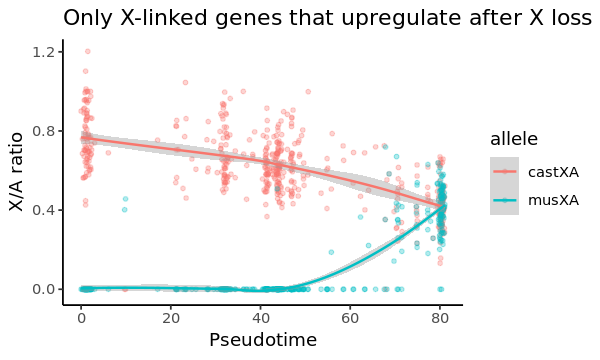

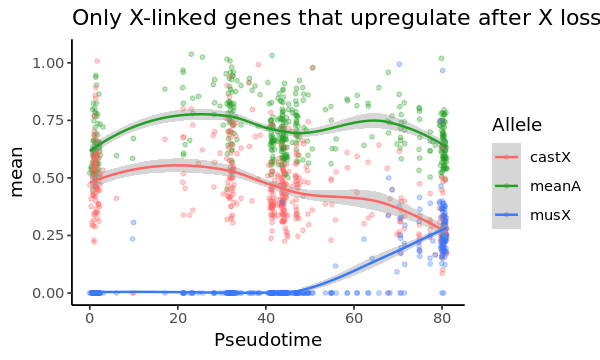

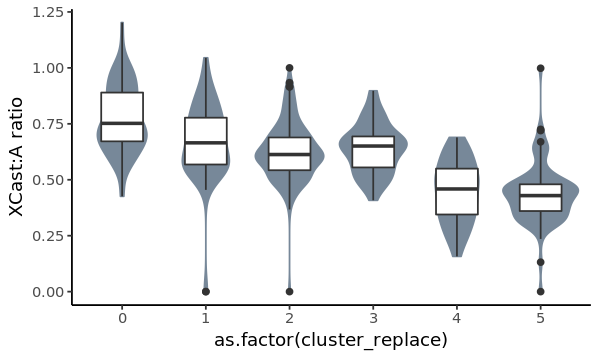

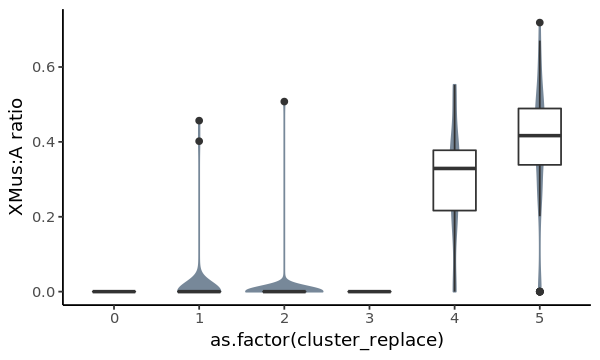


	Pairwise comparisons using Wilcoxon rank sum test 

data:  C0_C5_CastXA_test$mean and C0_C5_CastXA_test$cluster_replace 

  0       1       2       3       4      
1 0.00012 -       -       -       -      
2 2.5e-12 0.01207 -       -       -      
3 2.2e-06 0.19261 0.40058 -       -      
4 1.5e-14 4.3e-10 2.2e-09 5.6e-09 -      
5 < 2e-16 < 2e-16 < 2e-16 4.7e-14 0.49397

P value adjustment method: BH 

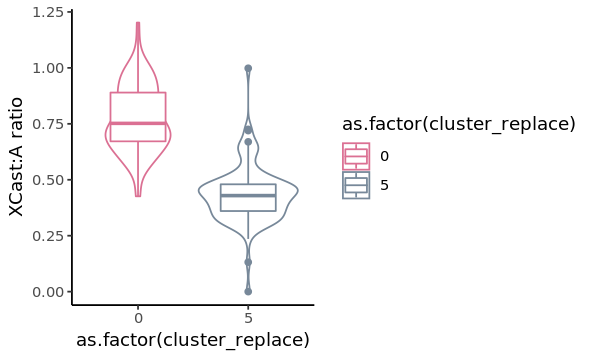


	Pairwise comparisons using Wilcoxon rank sum test 

data:  all_absCastX_test$mean and all_absCastX_test$cluster_replace 

  0       1       2       3       4     
1 0.5338  -       -       -       -     
2 0.0092  0.0025  -       -       -     
3 0.8155  0.4955  0.1613  -       -     
4 7.9e-10 9.2e-10 1.2e-08 3.0e-08 -     
5 < 2e-16 < 2e-16 < 2e-16 5.2e-12 0.2452

P value adjustment method: BH 

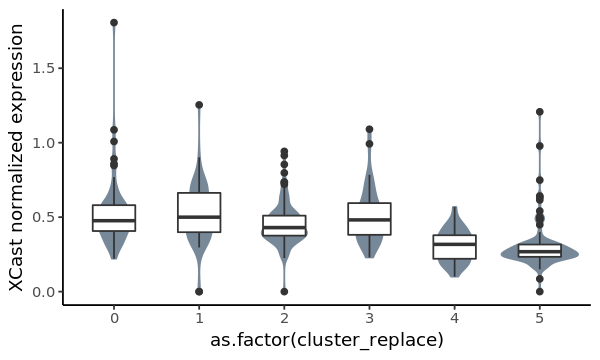

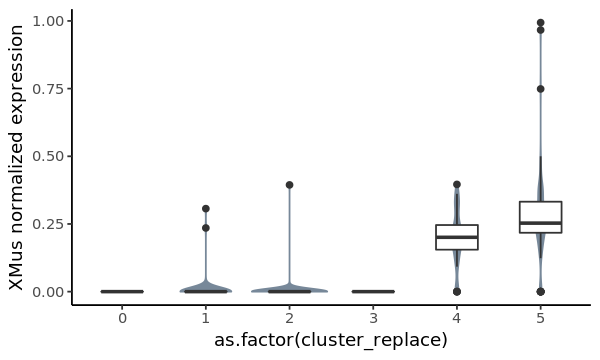

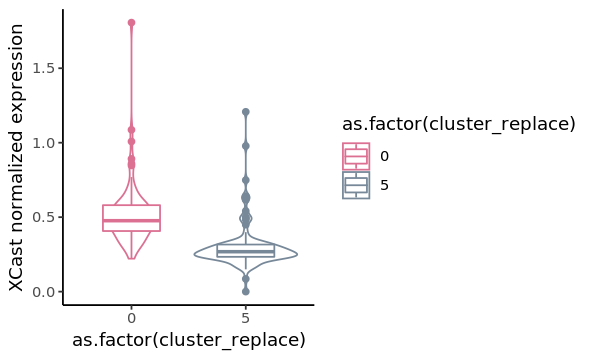

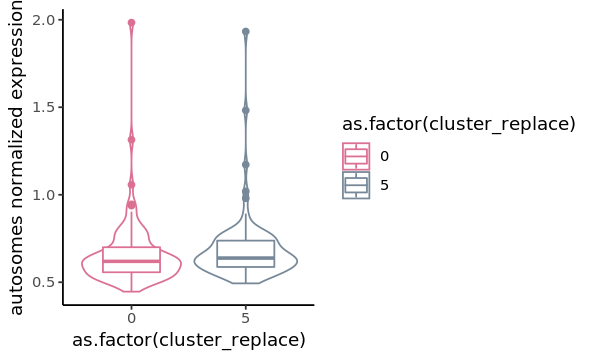

In [46]:
notA <- c("chrX", "chrY", "chrM")


filter <- c(0)
#filter <- 0
plotA2 <- list()
plotD2 <- list()

for(i in 1:length(filter)){
allelic2 <- allelic %>% filter(sum_norm > filter[i])
    
A <- allelic2 %>% filter(!Chr %in% notA) %>% select(RNA_id, mus_norm, cast_norm, sum_norm, cluster_replace, Pseudotime)
A <- A %>% group_by(RNA_id, Pseudotime, cluster_replace) %>% summarize(meanA = median(sum_norm), castA = median(cast_norm), musA = median(mus_norm))
    
X <- allelic2 %>% filter(Chr == "chrX", gene %in% upregulating_genes$gene) %>%  select(RNA_id, mus_norm, cast_norm, sum_norm)
X <- X %>% group_by(RNA_id) %>% summarize(castX = median(cast_norm), musX = median(mus_norm), meanX = median(sum_norm))

XA <- merge(A, X, by="RNA_id")
XA$castXA <- XA$castX/XA$meanA
XA$musXA <- XA$musX/XA$meanA

plot <- XA %>% gather(allele, mean, -RNA_id, -Pseudotime, -cluster_replace)

plotA <- plot %>% filter(allele=="castXA" | allele=="musXA")

options(repr.plot.width=5, repr.plot.height=2)
plotA2[[i]] <- ggplot(plotA, aes(Pseudotime, mean, color=allele)) +
                geom_point(size = 1, alpha = 0.3, aes(color = allele)) +
                geom_smooth(aes(group=allele), size = .7) +    
                ggtitle(paste0("cells: ", length(unique(chrX$RNA_id)), ", sum_norm > ", filter[i])) +
                theme_classic() + ylab("X/A ratio")+
                ggtitle("Only X-linked genes that upregulate after X loss")
    
plotD <- plot %>% filter(allele=="castX" | allele=="musX" | allele=="meanA")
options(repr.plot.width=5, repr.plot.height=3)
plotD2[[i]] <- ggplot(plotD, aes(Pseudotime, mean, color=allele)) +
                geom_point(size = 1, alpha = 0.3, aes(color = allele)) +
                geom_smooth(aes(group=allele), size = .7) +    
                ggtitle(paste0("cells: ", length(unique(chrX$RNA_id)), ", sum_norm > ", filter[i])) + ylim(0,1.05) +
               # + ylab("Median Expression")
                scale_color_manual(name="Allele",
                    values=c(meanA="#22A024", castX="#FF6565", musX = "#377AFF")) +
                theme_classic()    +
                        ggtitle("Only X-linked genes that upregulate after X loss")

}
plotA2
plotD2

# Plot box plot X/A ratio in MEF vs iPSCs and check with statistics
options(repr.plot.width=5, repr.plot.height=3)

# Cast X/A ratio - all clusters
all_CastXA_violin <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                ylab("XCast:A ratio")+
                theme_classic()
all_CastXA_violin

# Mus X/A ratio - all clusters
all_MusXA_violin <- plotA %>% filter(allele=="musXA", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                ylab("XMus:A ratio")+
                theme_classic()
all_MusXA_violin


# Cast X/A ratio
C0_C5_CastXA_violin <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin()+
                geom_boxplot(width = 0.5) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast:A ratio")
C0_C5_CastXA_violin
C0_C5_CastXA_test <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0:5))
pairwise.wilcox.test(C0_C5_CastXA_test$mean, C0_C5_CastXA_test$cluster_replace, p.adjust.method = "BH")

# Cast abs expression - all clusters
all_absCastX_violin <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast normalized expression")
all_absCastX_violin

all_absCastX_test <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0:5))
pairwise.wilcox.test(all_absCastX_test$mean, all_absCastX_test$cluster_replace, p.adjust.method = "BH")

# Mus abs expression - all clusters
all_absMusX_violin <- plotD %>% filter(allele=="musX", cluster_replace %in% c(0:5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean)) +
                geom_violin(fill = "lightslategray", color = "lightslategray")+
                geom_boxplot(width = 0.5) +
                #scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XMus normalized expression")
all_absMusX_violin


# Cast abs expression
C0_C5_absCastX_violin <- plotD %>% filter(allele=="castX", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin()+
                geom_boxplot(width = 0.5) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("XCast normalized expression")
C0_C5_absCastX_violin

# Autosomes absolute expresssion
C0_C5_absA_violin <- plotD %>% filter(allele=="meanA", cluster_replace %in% c(0,5)) %>% 
            ggplot(aes(as.factor(cluster_replace), mean, color = as.factor(cluster_replace))) +
                geom_violin()+
                geom_boxplot(width = 0.5) +
                scale_color_manual(values=c("palevioletred","lightslategray")) +
                theme_classic()+
                ylab("autosomes normalized expression")
C0_C5_absA_violin

In [45]:

C0_C5_CastXA_test <- plotA %>% filter(allele=="castXA", cluster_replace %in% c(0:5))

pairwise.wilcox.test(C0_C5_CastXA_test$mean, C0_C5_CastXA_test$cluster_replace, p.adjust.method = "BH")


	Pairwise comparisons using Wilcoxon rank sum test 

data:  C0_C5_CastXA_test$mean and C0_C5_CastXA_test$cluster_replace 

  0       1       2       3       4      
1 0.00012 -       -       -       -      
2 2.5e-12 0.01207 -       -       -      
3 2.2e-06 0.19261 0.40058 -       -      
4 1.5e-14 4.3e-10 2.2e-09 5.6e-09 -      
5 < 2e-16 < 2e-16 < 2e-16 4.7e-14 0.49397

P value adjustment method: BH 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


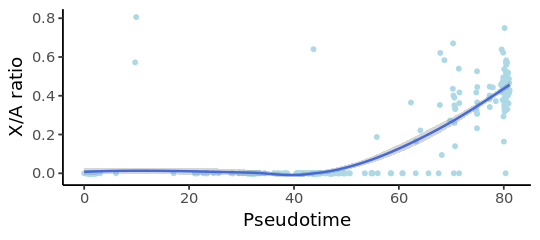

In [54]:
plotA <- plot %>% filter(allele=="musXA")

options(repr.plot.width=4.5, repr.plot.height=2)
Xmus_auto <- ggplot(plotA, aes(Pseudotime, mean, color=allele)) +
                geom_point(size = 1, alpha = 1, color = "lightblue") +
                geom_smooth(size = .7, color = "royalblue") +    
               
                theme_classic() + ylab("X/A ratio")
Xmus_auto

In [55]:
pdf("allele_specific/XCR/Xmus_Auto_ratio.pdf", useDingbats = FALSE, width = 4.5, height = 2)
plot(Xmus_auto)
dev.off()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


png 
  2

### Allele specific per gene

In [30]:
Xgene <- allelic %>% filter(Chr=="chrX") #%>% filter(sum_norm > 5)
Xgene <- Xgene %>% group_by(gene) %>% summarize(mean_sums=mean(sum_norm)) %>% arrange(desc(mean_sums)) %>% .$gene %>% head(50)

In [31]:
allelic %>% head()

X1,gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,...,Xi,X2,cluster,cluster_replace,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
1,0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,...,Mus,226,0,2,chr11,88329,0.00000000,0.0000000,NA,0.0000000
2,0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,...,Mus,58,4,3,chr11,10125,0.00000000,0.0000000,NA,0.0000000
3,0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,...,Mus,222,0,2,chr11,115942,0.00000000,0.2963941,0.0000000,0.2963941
4,0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,...,Mus,397,1,1,chr11,142685,0.06773757,0.3991728,0.1450762,0.4669104
5,0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,...,Mus,391,5,4,chr11,202247,0.00000000,0.0000000,NA,0.0000000
6,0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,...,Mus,11,0,2,chr11,181032,0.19963368,0.0000000,1.0000000,0.1996337


# Classify genes  
## Filter sum_norm > 0

In [59]:
allelic2 <- allelic %>% filter(Chr=="chrX") %>% filter(sum_norm > 0)
mef <- allelic2 %>% filter(Pseudotime <= 3)
inter <- allelic2 %>% filter(Pseudotime >= 20 & Pseudotime <= 60)
end <- allelic2 %>% filter(Pseudotime >= 78)

In [60]:
mef_gene <- mef %>% group_by(gene) %>% summarise(cast_mef=mean(cast_norm), mus_mef=mean(mus_norm), sum_mef=mean(sum_norm))
inter_gene <- inter %>% group_by(gene) %>% summarise(cast_inter=mean(cast_norm), mus_inter=mean(mus_norm), sum_inter=mean(sum_norm))
end_gene <- end %>% group_by(gene) %>% summarise(cast_end=mean(cast_norm), mus_end=mean(mus_norm), sum_end=mean(sum_norm))

In [61]:
genes <- merge(mef_gene, inter_gene,by="gene")
genes <- merge(genes, end_gene,by="gene")

In [62]:
genes$cast_mef_end <- genes$cast_end/genes$cast_mef*100
genes$mus_mef_end <- genes$mus_end/genes$mus_mef*100
genes$mus_mef_inter <- genes$mus_inter/genes$mus_mef*100
genes$cast_mef_inter <- genes$cast_inter/genes$cast_mef*100
genes$end_mus_cast <- genes$mus_end/genes$cast_end*100
genes$sum_mef_end <- genes$sum_end/genes$sum_mef*100

In [64]:
para <- list()
para$up <- 125
para$low <- 75

In [65]:
# Xi is devided in whether they end higher similar or lower than Xa
genes2 <- genes %>% select(gene, end_mus_cast, sum_mef_end)
Xi_high <- genes2 %>% filter(end_mus_cast >= para$up)
Xi_high$Xi <- "Higher"
Xi_same <- genes2 %>% filter(end_mus_cast > para$low & end_mus_cast < para$up)
Xi_same$Xi <- "Similar"
Xi_low <- genes2 %>% filter(end_mus_cast <= para$low)
Xi_low$Xi <- "Lower"

Xi <- rbind(Xi_high, Xi_same, Xi_low)
Xi <- Xi %>% select(gene, Xi, sum_mef_end)

In [66]:
# Xa is devidied in whether it goes up, stays similar of goes down at the end of reprogramming respective to the beginning
genes2 <- genes %>% select(gene, cast_mef_end)
Xa_high <- genes2 %>% filter(cast_mef_end >= para$up)
Xa_high$Xa <- "Higher"
Xa_same <- genes2 %>% filter(cast_mef_end > para$low & cast_mef_end < para$up)
Xa_same$Xa <- "Similar"
Xa_low <- genes2 %>% filter(cast_mef_end <= para$low)
Xa_low$Xa <- "Lower"

genes2 <- genes %>% select(gene, cast_mef_end, cast_mef_inter)
Xa_inter_up <- genes2 %>% filter(cast_mef_end > para$low & cast_mef_end < para$up & cast_mef_inter >=para$up)
Xa_inter_up$Xa_inter <- "Higher"
Xa_inter_same <- genes2 %>% filter(cast_mef_end > para$low & cast_mef_end < para$up & cast_mef_inter > para$low & cast_mef_inter < para$up)
Xa_inter_same$Xa_inter <- "Similar"
Xa_inter_down <- genes2 %>% filter(cast_mef_end > para$low & cast_mef_end < para$up & cast_mef_inter <=para$low )
Xa_inter_down$Xa_inter <- "Lower"

genes2 <- genes %>% select(gene, sum_mef_end)
sum_high <- genes2 %>% filter(sum_mef_end >= para$up)
sum_high$sum <- "Higher"
sum_same <- genes2 %>% filter(sum_mef_end > para$low & sum_mef_end < para$up)
sum_same$sum <- "Similar"
sum_low <- genes2 %>% filter(sum_mef_end <= para$low)
sum_low$sum <- "Lower"


Xa <- rbind(Xa_high, Xa_same, Xa_low)
Xa <- Xa %>% select(gene, Xa)
Xa_inter <- rbind(Xa_inter_up, Xa_inter_same , Xa_inter_down )
Xa_inter <- Xa_inter %>% select(gene, Xa_inter)
sum <- rbind(sum_high, sum_same, sum_low)
sum <- sum %>% select(gene, sum)

In [67]:
X_catagories <- merge(Xi, Xa, by="gene", all=TRUE)
X_catagories <- merge(X_catagories, Xa_inter, by="gene", all=TRUE)
X_catagories <- merge(X_catagories, sum, by="gene", all=TRUE)

In [68]:
X_catagories$Xi <- factor(X_catagories$Xi, levels=c("Lower", "Similar", "Higher"))
X_catagories$Xa <- factor(X_catagories$Xa, levels=c("Lower", "Similar", "Higher"))
X_catagories$sum <- factor(X_catagories$sum, levels=c("Lower", "Similar", "Higher"))
X_catagories <- X_catagories %>% filter(Xi != "NA" & Xa != "NA" & sum != "NA")

In [72]:
Xgene <- allelic %>% filter(Chr=="chrX")
Xgene <- Xgene %>% 
            group_by(gene) %>% 
            summarize(mean_sums=mean(sum_norm)) %>% 
            arrange(desc(mean_sums)) %>% .$gene

set <- c(50,100,150,200,250,300,350,400)

plots <- list()
for(i in 1:length(set)){
top_X <- head(Xgene, set[i])
X_high <- X_catagories %>% filter(gene %in% top_X)
plots[[i]] <- ggplot(X_high, aes(Xa, fill=Xi)) + geom_bar() + theme_bw() + facet_grid(~ sum) + ggtitle(set[i])
#plots[[i]] <- ggplot(X_catagories, aes(Xa, fill=Xi)) + geom_bar() + theme_bw() + facet_grid(~ sum)+ ggtitle(set[i])
}

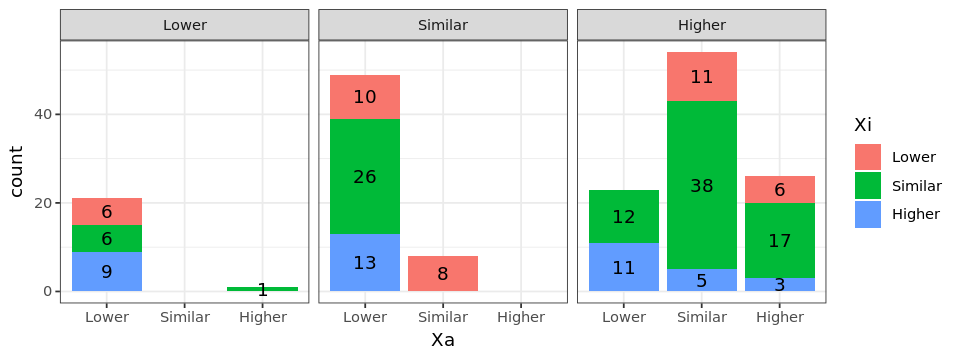

In [77]:
options(repr.plot.width=8, repr.plot.height=3)

top_X <- head(Xgene, 200)
X_high <- X_catagories %>% 
            filter(gene %in% top_X)

plot_count <- ggplot(X_high, aes(Xa, fill=Xi)) + 
                geom_bar() + 
                theme_bw() + 
                facet_grid(~ sum) + 
                geom_text(stat='count', aes(label=..count..),position = position_stack(vjust = .5) )
plot_count

In [ ]:
pdf(paste0("allele_specific/XCU/Ad_Xa_count_top200_Filtered_sum_norm.pdf"), useDingbats = FALSE, height=3, width=8)
plot_count
dev.off()

# Define the kinetics of XCR using directly expression of Cast allele (Not Mus/Cast ratio)

In [38]:
# Wrap fitting and adding model to the input df in a single function

fit_n_add <- function(data, y, x, gene, range, span = 0.75){
    
    # Create model that will do the same thing as under the hood in ggplot2
        model <- loess(y ~ x, data = data, span = span)

    # Add predicted values from model to original dataset using broom library
        # This is not going to be used, but might be useful other time
        # df <- augment(model, data)
    
    # Create a new data frame which links gene and fitted norm_ratio value for the pseudotime range of 0:80
    
    predicted <- predict(model, newdata = range, se = TRUE)
    
    df <- data.frame(gene = gene, pseudotime = range, fitted_data = predicted$fit)
    
    return(df)
}

In [39]:
# Calculate fitted lines for all cluster consistent X-linked genes

library(purrr)

allelic_fit_chrX_clust_cons_dir <- allelic %>% filter(sum_norm > 0) %>% filter(gene %in% consistent_cluster$gene) %>%
                                group_split(gene) %>%
                                map(~fit_n_add(data = .,
                                               y = .$cast_norm,
                                               x = .$Pseudotime,
                                               gene = .$gene[1],
                                               range = 2:80)) %>%
                                bind_rows() 

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding cha

In [40]:
allelic_fit_chrX_clust_cons_dir %>% head()

gene,pseudotime,fitted_data
1110012L19Rik,2,0.6557344
1110012L19Rik,3,0.6598351
1110012L19Rik,4,0.6642745
1110012L19Rik,5,0.6690272
1110012L19Rik,6,0.6740681
1110012L19Rik,7,0.6793718


In [41]:
# K-means clustering based on fitted trends
library(tibble)
allelic_fit_chrX_clust_cons_mtx <- allelic_fit_chrX_clust_cons_dir %>% filter(gene != "Xist") %>% spread(pseudotime, fitted_data) %>% column_to_rownames("gene")

# Compute k-means with k = 6
set.seed(123)
km.res.fit <- kmeans(allelic_fit_chrX_clust_cons_mtx, 5,iter.max = 100, nstart = 100)

allelic_fit_kmeans <- cbind(allelic_fit_chrX_clust_cons_mtx, k_means_cluster = km.res.fit$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

allelic_fit_kmeans_long <- allelic_fit_kmeans %>%
                                    gather(pseudotime, fitted_data,-gene, -k_means_cluster) 

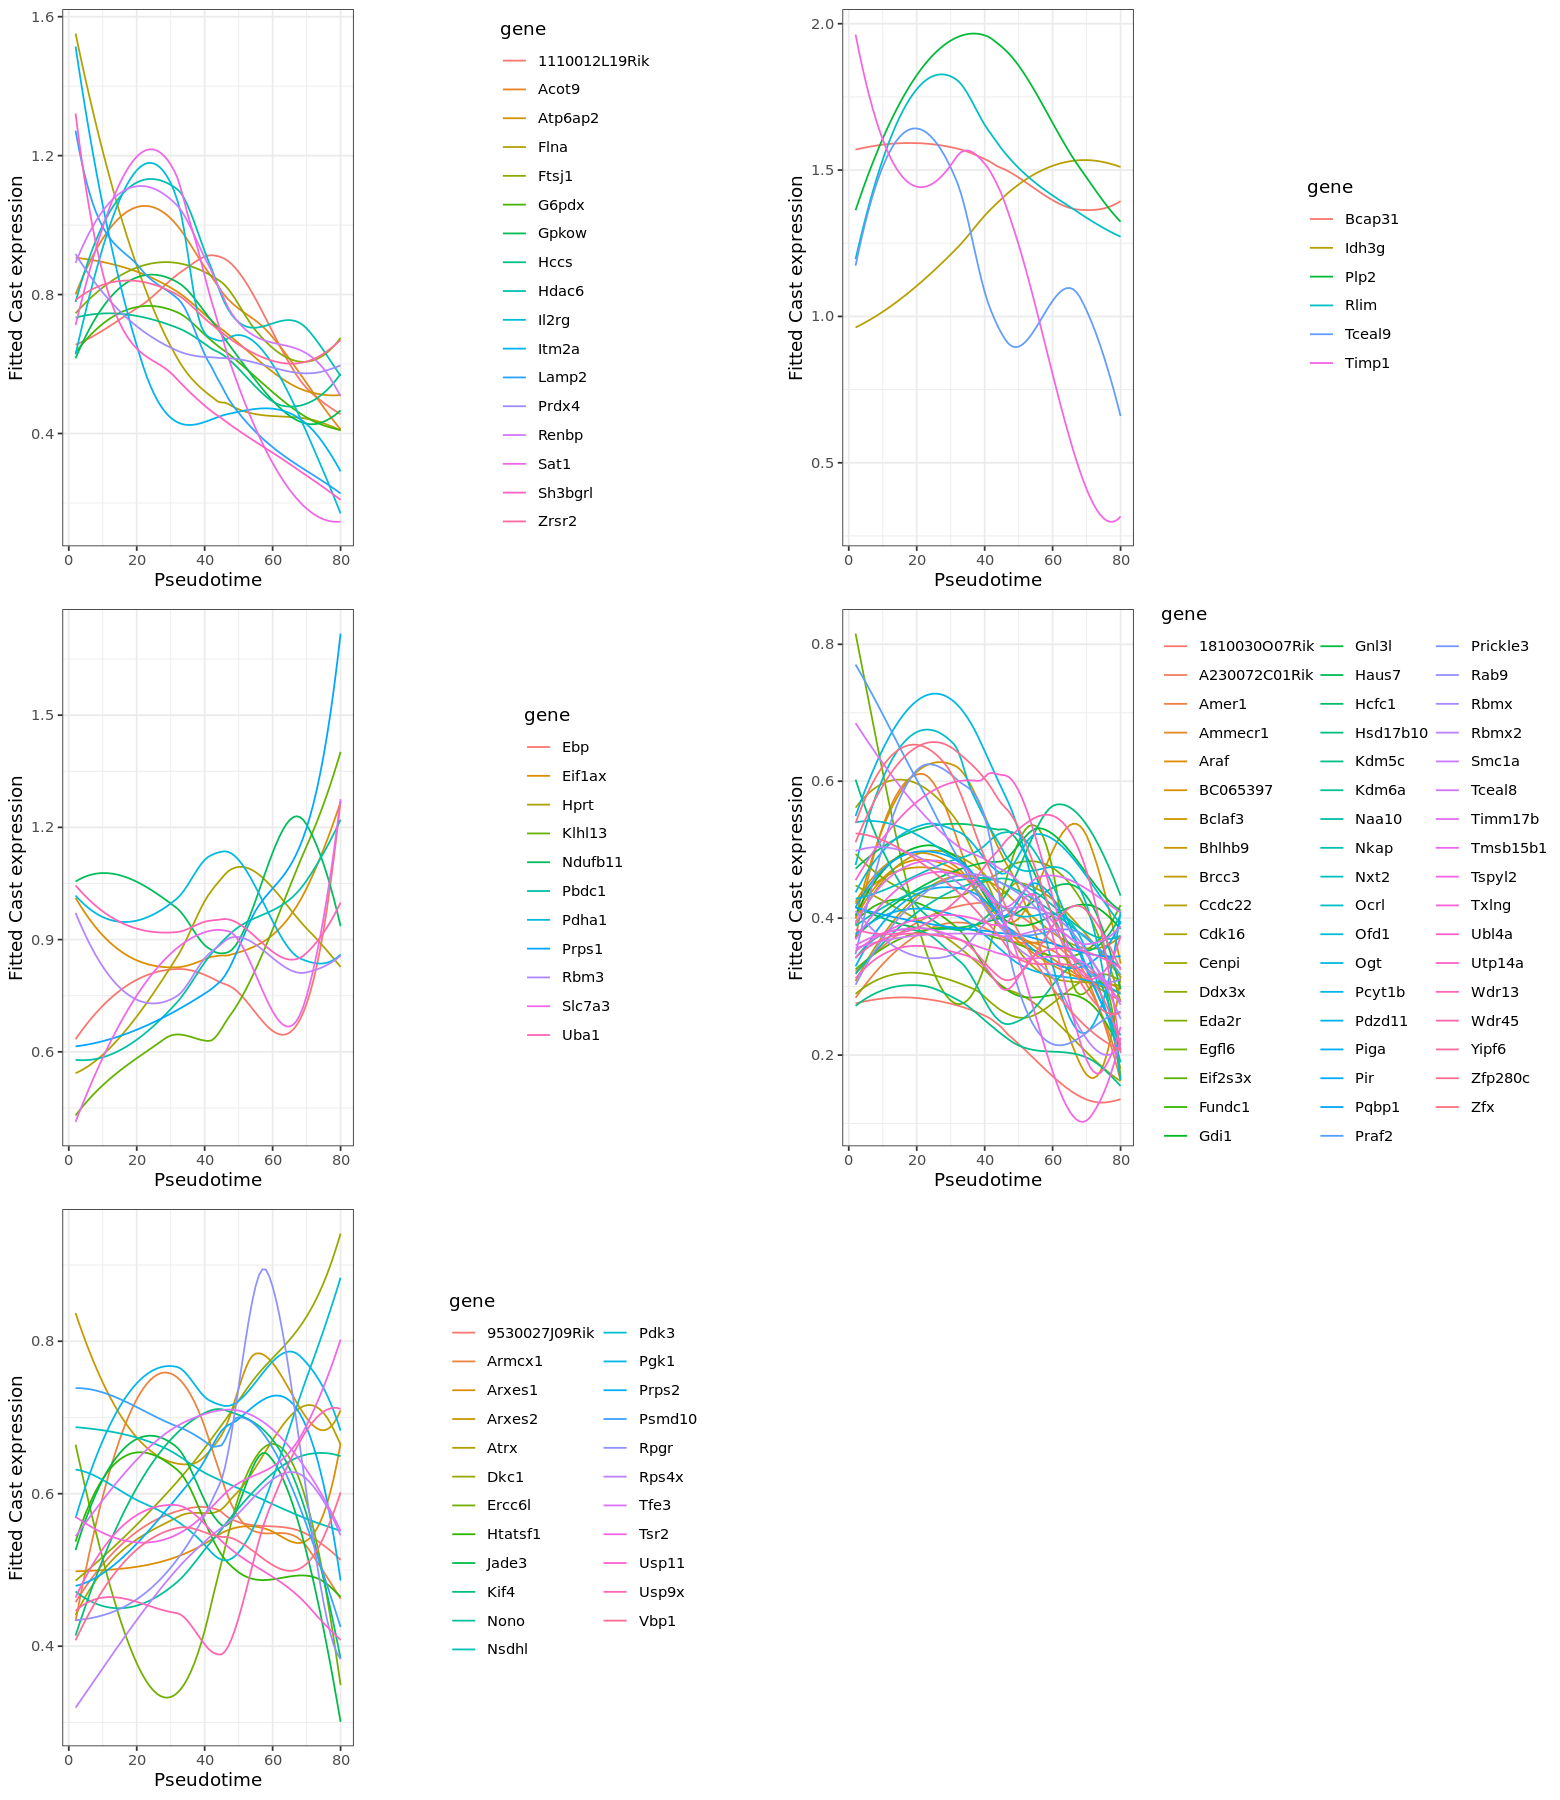

In [42]:
# Visualize clustered fitted models

kinetics_k_fit_plots <- list()

for (i in seq(unique(allelic_fit_kmeans_long$k_means_cluster))){
    
kinetics_k_fit_plots[[i]] <- allelic_fit_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(as.integer(pseudotime), fitted_data, group = gene, color = gene)) +
                                geom_line() +
                                #geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                            # coord_cartesian(ylim = c(0,1))+
                                ylab("Fitted Cast expression")+
                                xlab("Pseudotime") +
                                theme_bw()
                                
    }

options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_fit_plots, ncol=2)

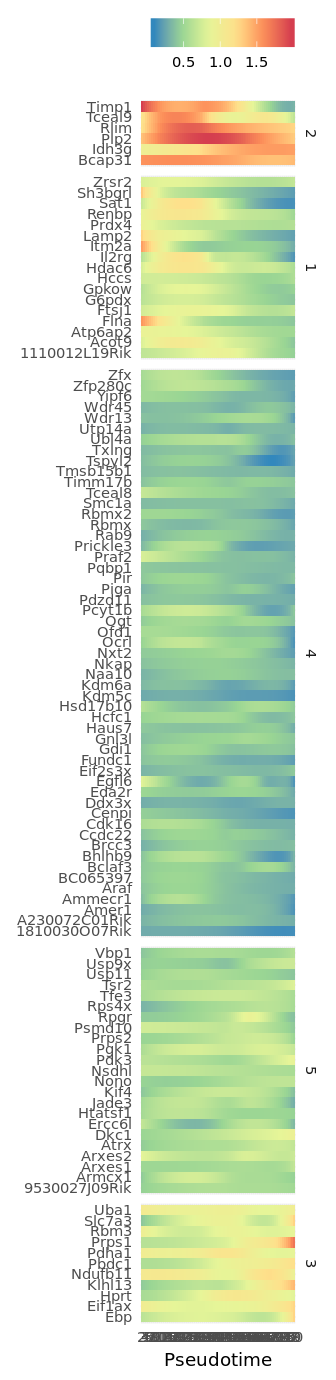

In [47]:
options(repr.plot.width=2.8, repr.plot.height=11.5)

allelic_fit_kmeans_long$pseudotime_fct <- factor(allelic_fit_kmeans_long$pseudotime, levels = sort(unique(as.integer(allelic_fit_kmeans_long$pseudotime))))
allelic_fit_kmeans_long$k_means_cluster <- factor(allelic_fit_kmeans_long$k_means_cluster, levels = c(2,1,4,5,3))

allelic_fit_kmeans_long_expression <- allelic_fit_kmeans_long %>% 
            ggplot(aes(x = pseudotime_fct, y = gene, fill = fitted_data)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime", fill = "") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank())
allelic_fit_kmeans_long_expression

In [48]:
pdf("allele_specific/XCU/allelic_fit_heatmap_Cast_expr.pdf", width=2.8, height=11.5)
plot(allelic_fit_kmeans_long_expression)
dev.off()

png 
  2